# Graph Neural Network (GNN)-based Synthetic Binding Logic Classification plus Graph-SafeML
The eisting example of GNN-based Synthetic Binding Logic Classification from google research team is used to test the idea of SafeML for Graph-based classifiers. You can find the source code [here](https://github.com/google-research/graph-attribution) and the related paper for the code is available [here](https://papers.nips.cc/paper/2020/file/417fbbf2e9d5a28a855a11894b2e795a-Paper.pdf) [[1]](https://papers.nips.cc/paper/2020/file/417fbbf2e9d5a28a855a11894b2e795a-Paper.pdf).
Regarding the Graph-based distance measure, the theory of "Graph distance for complex networks" provided by of Yutaka Shimada et al. is used [[2]](https://www.nature.com/articles/srep34944). The code related to this paper is avaialble [here](https://github.com/msarrias/graph-distance-for-complex-networks).
You can read more about the idea of SafeML in [[3]](https://github.com/ISorokos/SafeML). To read more about "Synthetic Binding Logic Classification" and the related dataset that is used in this notebook, please check [[4]](https://www.pnas.org/content/pnas/116/24/11624.full.pdf).

![SafeML logo from: https://github.com/ISorokos/SafeML](https://miro.medium.com/max/700/1*H0lN2Q9lmSRgfaGj9VqqGA.png)

The SafeML project takes place at the University of Hull in collaboration with Fraunhofer IESE and Nuremberg Institute of Technology


## Table of Content
* [Initialization and Installations](#init)
* [Importing Required Libraries](#lib)
* [Graph Attribution Specific Imports](#glib)
* [Load Experiment Data, Task and Attribution Techniques](#load)
* [Creating a GNN Model](#model)
* [Graph Vizualization](#gviz)
* [Graph Distance Measures and SafeML Idea](#SafeML)
* [Discussion](#dis)

### References:
[[1]. Wiltschko, A. B., Sanchez-Lengeling, B., Lee, B., Reif, E., Wei, J., McCloskey, K. J., & Wang, Y. (2020). Evaluating Attribution for Graph Neural Networks.](https://papers.nips.cc/paper/2020/file/417fbbf2e9d5a28a855a11894b2e795a-Paper.pdf)

[[2]. Shimada, Y., Hirata, Y., Ikeguchi, T., & Aihara, K. (2016). Graph distance for complex networks. Scientific reports, 6(1), 1-6.](https://www.nature.com/articles/srep34944)

[[3]. Aslansefat, K., Sorokos, I., Whiting, D., Kolagari, R. T., & Papadopoulos, Y. (2020, September). SafeML: Safety Monitoring of Machine Learning Classifiers Through Statistical Difference Measures. In International Symposium on Model-Based Safety and Assessment (pp. 197-211). Springer, Cham.](https://arxiv.org/pdf/2005.13166.pdf)

[[4]. McCloskey, K., Taly, A., Monti, F., Brenner, M. P., & Colwell, L. J. (2019). Using attribution to decode binding mechanism in neural network models for chemistry. Proceedings of the National Academy of Sciences, 116(24), 11624-11629.](https://www.pnas.org/content/pnas/116/24/11624.full.pdf)

<a id = "init"></a>
## Initialization and Installations

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import sys

IN_COLAB = 'google.colab' in sys.modules
REPO_DIR = '..' if IN_COLAB  else '..'

In [2]:
!git clone https://github.com/google-research/graph-attribution.git --quiet
    
import sys
sys.path.insert(1, '/kaggle/working/graph-attribution')

In [3]:
!pip install tensorflow tensorflow-probability -q
!pip install dm-sonnet -q
!pip install graph_nets "tensorflow>=2.1.0-rc1" "dm-sonnet>=2.0.0b0" tensorflow_probability
!pip install git+https://github.com/google-research/graph-attribution -quiet

     |████████████████████████████████| 76 kB 344 kB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91865 sha256=8c2879644c60ba0fa7f80c9305b896fdbcad697b66a7928f68e142400aea0ccd
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets

Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -u


In [4]:
!pip install git+https://github.com/google-research/graph-attribution

  Cloning https://github.com/google-research/graph-attribution to /tmp/pip-req-build-2z5mal8c
  Running command git clone -q https://github.com/google-research/graph-attribution /tmp/pip-req-build-2z5mal8c
     |████████████████████████████████| 88 kB 359 kB/s 
  Created wheel for graph-attribution: filename=graph_attribution-1.0.0b0-py3-none-any.whl size=50933 sha256=4c24f7905272693b500c1445dbccd4689eab8df0313f394f526e904f0c0855f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-yhsk3mmq/wheels/a3/b8/23/fb9853106c701cdaf9831913a2044299fe770d6efd36098629
Successfully built graph-attribution


<a id = "lib"></a>
## Importing Required Libraries

In [5]:
import os
import itertools
import collections
import tqdm.auto as tqdm

from IPython.display import display

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import sonnet as snt
import graph_nets
from graph_nets.graphs import GraphsTuple
import graph_attribution as gatt

from tqdm import tqdm

import time

import networkx as nx

# Ignore tf/graph_nets UserWarning:
# Converting sparse IndexedSlices to a dense Tensor of unknown shape
import warnings
warnings.simplefilter("ignore", UserWarning)

for mod in [tf, snt, gatt]:
    print(f'{mod.__name__:20s} = {mod.__version__}')

rdkit detected? False
tensorflow           = 2.4.1
sonnet               = 2.0.0
graph_attribution    = 1.0.0b


<a id = "glib"></a>
## Graph Attribution specific imports

In [6]:
from graph_attribution import tasks
from graph_attribution import graphnet_models as gnn_models
from graph_attribution import graphnet_techniques as techniques
from graph_attribution import datasets
from graph_attribution import experiments
from graph_attribution import templates
from graph_attribution import graphs as graph_utils

#datasets.DATA_DIR = os.path.join(REPO_DIR, 'data')
#print(f'Reading data from: {datasets.DATA_DIR}')

datasets.DATA_DIR = './graph-attribution/data'

<a id = "load"></a>
# Load Experiment Data, Task and Attribution Techniques

In [7]:
print(f'Available tasks: {[t.name for t in tasks.Task]}')
print(f'Available model types: {[m.name for m in gnn_models.BlockType]}')
print(f'Available ATT techniques: {list(techniques.get_techniques_dict(None,None).keys())}')

Available tasks: ['benzene', 'logic7', 'logic8', 'logic10', 'crippen', 'bashapes', 'treegrid', 'bacommunity']
Available model types: ['gcn', 'gat', 'mpnn', 'graphnet']
Available ATT techniques: ['Random', 'GradInput', 'SmoothGrad(GradInput)', 'GradCAM-last', 'GradCAM-all', 'CAM']


In [8]:
task_type = 'logic7'
block_type = 'gcn'

#task_dir = datasets.get_task_dir(task_type)
task_dir = './graph-attribution/data/logic7'
exp, task, methods = experiments.get_experiment_setup(task_type, block_type)
task_act, task_loss = task.get_nn_activation_fn(), task.get_nn_loss_fn()
graph_utils.print_graphs_tuple(exp.x_train)
print(f'Experiment data fields:{list(exp.__dict__.keys())}')

Shapes of GraphsTuple's fields:
GraphsTuple(nodes=TensorShape([81088, 14]), edges=TensorShape([172570, 5]), receivers=TensorShape([172570]), senders=TensorShape([172570]), globals=TensorShape([3840, 1]), n_node=TensorShape([3840]), n_edge=TensorShape([3840]))
Experiment data fields:['x_train', 'x_test', 'y_train', 'y_test', 'att_test', 'x_aug', 'y_aug']


<a id = "model"></a>
## Creating a GNN Model

### Defining Hyperparams of the Experiment

In [9]:
hp = gatt.hparams.get_hparams({'block_type':block_type, 'task_type':task_type})
hp

batch_size: 256
block_type: gcn
edge_size: 20
epochs: 300
global_size: 100
learning_rate: 0.0003
n_layers: 3
node_size: 50
random_seed: 42
task_type: logic7

### Instantiate model

In [10]:
model = experiments.GNN(node_size = hp.node_size,
               edge_size = hp.edge_size,
               global_size = hp.global_size,
               y_output_size = task.n_outputs,
               block_type = gnn_models.BlockType(hp.block_type),
               activation = task_act,
               target_type = task.target_type,
               n_layers = hp.n_layers)
model(exp.x_train)
gnn_models.print_model(model)

GNN : gcn

| Variable                                  | Spec        | Trainable   | Device   |
|-------------------------------------------+-------------+-------------+----------|
| gcn/ReadoutGAP/linear/w                   | f32[20,100] | True        | CPU      |
| gcn/ReadoutGAP/linear/w                   | f32[50,100] | True        | CPU      |
| gcn/ReadoutGAP/linear/b                   | f32[100]    | True        | CPU      |
| gcn/ReadoutGAP/linear/b                   | f32[100]    | True        | CPU      |
| gcn/gcn_1/layer_norm/offset               | f32[50]     | True        | CPU      |
| gcn/gcn_1/layer_norm/scale                | f32[50]     | True        | CPU      |
| gcn/gcn_1/mlp/linear_0/w                  | f32[120,50] | True        | CPU      |
| gcn/gcn_1/mlp/linear_0/b                  | f32[50]     | True        | CPU      |
| gcn/gcn_1/mlp/linear_1/w                  | f32[50,50]  | True        | CPU      |
| gcn/gcn_1/mlp/linear_1/b                  | f32[50] 

<a id ="train"></a>
## Training the GNN Model

In [11]:
optimizer = snt.optimizers.Adam(hp.learning_rate)

opt_one_epoch = gatt.training.make_tf_opt_epoch_fn(exp.x_train, exp.y_train, hp.batch_size, model,
                                      optimizer, task_loss)

pbar = tqdm(range(hp.epochs))
losses = collections.defaultdict(list)
start_time = time.time()
for _ in pbar:
    train_loss = opt_one_epoch(exp.x_train, exp.y_train).numpy()
    losses['train'].append(train_loss)
    losses['test'].append(task_loss(exp.y_test, model(exp.x_test)).numpy())
    #pbar.set_postfix({key: values[-1] for key, values in losses.items()})

losses = {key: np.array(values) for key, values in losses.items()}

100%|██████████| 300/300 [05:54<00:00,  1.18s/it]


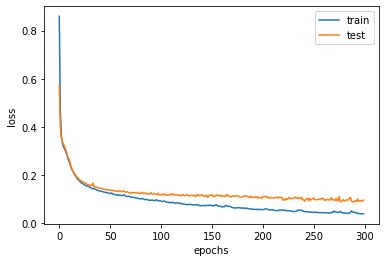

In [12]:
# Plot losses
for key, values in losses.items():
    plt.plot(values, label=key)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

In [13]:
y_pred = model(exp.x_test).numpy()
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
#y_pred

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(accuracy_score(exp.y_test, y_pred))

print(confusion_matrix(exp.y_test, y_pred))

print(classification_report(exp.y_test, y_pred))

0.9588477366255144
[[432   7]
 [ 13  34]]
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       439
         1.0       0.83      0.72      0.77        47

    accuracy                           0.96       486
   macro avg       0.90      0.85      0.88       486
weighted avg       0.96      0.96      0.96       486



In [14]:
# Evaluate predictions and attributions
results = []
for method in tqdm(methods.values(), total=len(methods)):
    results.append(experiments.generate_result(model, method, task, exp.x_test, exp.y_test, exp.att_test))
pd.DataFrame(results)

100%|██████████| 7/7 [02:40<00:00, 22.93s/it]


,ATT AUROC,ATT F1,ATT ACC,AUROC,F1,ACC,Task,Technique,Model
0,0.406980,0.031471,0.019034,0.987156,0.842105,0.969136,logic7,Random,gcn
1,0.709618,0.042547,0.119134,0.987156,0.842105,0.969136,logic7,GradInput,gcn
2,0.706156,0.039053,0.340033,0.987156,0.842105,0.969136,logic7,SmoothGrad(GradInput),gcn
3,0.693290,0.043864,0.116932,0.987156,0.842105,0.969136,logic7,GradCAM-last,gcn
4,0.780445,0.045759,0.118281,0.987156,0.842105,0.969136,logic7,GradCAM-all,gcn
5,0.587966,0.033544,0.744692,0.987156,0.842105,0.969136,logic7,IG,gcn
6,0.928201,0.078631,0.956974,0.987156,0.842105,0.969136,logic7,CAM,gcn


<a id = "gviz"></a>
## Graph Vizualization

In [15]:
# Source: https://notebook.community/deepmind/graph_nets/graph_nets/demos/graph_nets_basics
graphs_nx = graph_nets.utils_np.graphs_tuple_to_networkxs(exp.x_test)

def nx_g_plotter(graphs_nx, ColNum=8, node_clr='#ff8080'):
    _, axs = plt.subplots(ncols=ColNum, nrows = 1, figsize=(30, 5))
    for iax, (graph_nx2, ax) in enumerate(zip(graphs_nx, axs)):
        nx.draw(graph_nx2, ax=ax, node_color=node_clr)
        ax.set_title("Graph {}".format(iax))

In [16]:
!git clone https://github.com/msarrias/graph-distance-for-complex-networks --quiet

import sys
sys.path.insert(1, '/kaggle/working/graph-distance-for-complex-networks')

<a id = "xwhy"></a>
## X-Why for Graph Edge Explainability

In [17]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
import scipy.linalg as la
import networkx as nx
import random, time, math
from collections import Counter

import fun as f
from Graph import Graph
from Watts_Strogatz import watts_strogatz_graph
from Erdos_Renyi import erdos_renyi_graph

from sklearn.linear_model import LinearRegression

def Wasserstein_Dist(cdfX, cdfY):
  
    Res = 0
    power = 1
    n = len(cdfX)

    for ii in range(0, n-2):
        height = abs(cdfX[ii]-cdfY[ii])
        width = cdfX[ii+1] - cdfX[ii]
        Res = Res + (height ** power) * width 
 
    return Res


def r_eigenv(G_i, G_j):
    #Eigen-decomposition of G_j
    A_Gi = (nx.adjacency_matrix(G_i)).todense()
    D_i = np.diag(np.asarray(sum(A_Gi))[0])
    eigenvalues_Gi, eigenvectors_Gi = la.eig(D_i - A_Gi)
    r_eigenv_Gi = sorted(zip(eigenvalues_Gi.real, eigenvectors_Gi.T), key=lambda x: x[0])

    #Eigen-decomposition of G_j
    A_Gj = (nx.adjacency_matrix(G_j)).todense()
    D_j = np.diag(np.asarray(sum(A_Gj))[0])
    eigenvalues_Gj, eigenvectors_Gj = la.eig(D_j - A_Gj)
    r_eigenv_Gj = sorted(zip(eigenvalues_Gj.real, eigenvectors_Gj.T), key=lambda x: x[0])
    
    r = 4
    signs =[-1,1]
    temp = []
    for  sign_s in signs:
        for sign_l in signs:
            vri = sorted(f.normalize_eigenv(sign_s * r_eigenv_Gi[r][1]))
            vrj = sorted(f.normalize_eigenv(sign_l * r_eigenv_Gj[r][1]))
            cdf_dist = f.cdf_dist(vri, vrj)
            temp.append(cdf_dist)
    
    #Compute empirical CDF
    step = 0.005
    x=np.arange(0, 1, step)
    cdf_grid_Gip = f.cdf(len(r_eigenv_Gi[r][1]),x,
                   f.normalize_eigenv(sorted(r_eigenv_Gi[r][1], key=lambda x: x)))
    cdf_grid_Gin = f.cdf(len(r_eigenv_Gi[r][1]),x,
                   f.normalize_eigenv(sorted(-r_eigenv_Gi[r][1], key=lambda x: x)))

    cdf_grid_Gjp = f.cdf(len(r_eigenv_Gj[r][1]),x,
                   f.normalize_eigenv(sorted(r_eigenv_Gj[r][1], key=lambda x: x)))
    cdf_grid_Gjn = f.cdf(len(r_eigenv_Gj[r][1]),x,
                   f.normalize_eigenv(sorted(-r_eigenv_Gj[r][1], key=lambda x: x)))
    
    WD1 = Wasserstein_Dist(cdf_grid_Gip, cdf_grid_Gjp)
    WD2 = Wasserstein_Dist(cdf_grid_Gip, cdf_grid_Gjn)
    WD3 = Wasserstein_Dist(cdf_grid_Gin, cdf_grid_Gjp)
    WD4 = Wasserstein_Dist(cdf_grid_Gin, cdf_grid_Gjn)

    WD = [WD1, WD2, WD3, WD4]
    
    return max(temp), max(WD)

def xwhy_graph_edges(X_input_graph, model=model, num_perturb = 50, kernel_width = 0.25, num_top_features = 10, eps=1):    
    #num_perturb = 5000
    
    num_uniqe_words = len(X_input_graph.edges)

    perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_uniqe_words))

    def perturb_graph_edge(input_graph, perturbation):
        perturbed_graph = input_graph.copy()
        ebun = []
        for ii, ed in enumerate(perturbed_graph.edges):
            if perturbation[ii] == 0:
                ebun.append(ed)
        perturbed_graph.remove_edges_from(ebun)
        return perturbed_graph
        
    predictions = []
    WD_dist = []
    for pert in perturbations:
        p_graph = perturb_graph_edge(X_input_graph, pert)
        pred = model.predict(graph_nets.utils_np.networkxs_to_graphs_tuple([p_graph]))
        predictions.append(pred)
        Sscore, WD_score = r_eigenv(X_input_graph, p_graph)
        WD_dist.append(WD_score)

    predictions = np.array(predictions)   
    WD_dist = np.array(WD_dist) 
    
    weights = np.sqrt(np.exp(-((eps*WD_dist)**2)/kernel_width**2)) #Kernel function
    
#     print(perturbations.shape)
    
#     print(predictions.shape)
    
#     print(weights.shape)
    
#     print(predictions[:,:,0].shape)
                
    class_to_explain = 0
    simpler_model = LinearRegression()
    simpler_model.fit(X=perturbations, y=predictions, sample_weight=weights)
    coeff = simpler_model.coef_[0]
    
    top_features = np.argsort(abs(coeff))[-num_top_features:] 
    
    coeff2 = simpler_model.coef_
    
    # https://stackoverflow.com/questions/39626401/how-to-get-odds-ratios-and-other-related-features-with-scikit-learn
    odds = np.exp(coeff2)
    
    from sklearn.preprocessing import normalize

    Bounded_coeff = 2*(normalize(coeff[:,np.newaxis], axis=0).ravel()+1)
    
    return coeff, odds, top_features, Bounded_coeff, simpler_model 

In [18]:
%%time
coeff, odds, top_features, Bounded_coeff, simpler_model  = xwhy_graph_edges(graphs_nx[0], model=model, num_perturb = 5000, kernel_width = 0.25, num_top_features = 10, eps=1)

top_features

CPU times: user 1min 18s, sys: 1.42 s, total: 1min 19s
Wall time: 1min 14s


array([18, 32, 19,  2,  7,  5,  4,  6,  8,  9])

In [19]:
Bounded_coeff

array([2.0485467 , 1.86164332, 1.80422125, 1.98815388, 1.22891048,
       2.48619295, 2.92744283, 2.41422641, 2.96573673, 1.02037554,
       1.93517947, 1.97235973, 1.86682485, 2.00305074, 1.95288642,
       1.93548131, 1.95143165, 2.01163051, 1.85311592, 1.84578649,
       2.0895393 , 1.91621401, 1.97970559, 1.90399332, 1.93787218,
       1.98785661, 2.12953798, 2.06193612, 1.8802929 , 1.96918755,
       1.95791494, 1.88979102, 2.15230923, 2.07996728])

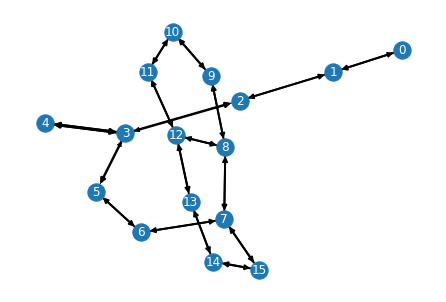

In [20]:
pos = nx.spring_layout(graphs_nx[0])

nx.draw(graphs_nx[0], pos=pos, width=Bounded_coeff, with_labels=True, font_color='white',cmap='PiYG')

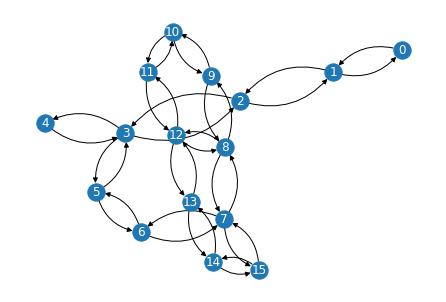

In [21]:
nx.draw(graphs_nx[0], pos=pos, with_labels=True, font_color='white',connectionstyle='arc3, rad = 0.35')

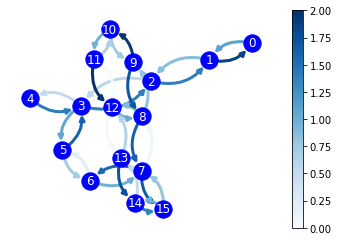

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import random

G = graphs_nx[0].copy()
# G = nx.gnp_random_graph(10,0.3)
for u,v,d in G.edges(data=True):
    d['weight'] = random.random()

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

# pos = nx.spring_layout(G)
fig, ax = plt.subplots()

nnn = nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues,with_labels=True, 
        font_color='white',connectionstyle='arc3, rad = 0.35', ax = ax)

colors=range(3)
cmap=plt.cm.Blues
vmin = min(colors)
vmax = max(colors)
# nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors, width=4, edge_cmap=cmap,
#            with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm)
plt.show()

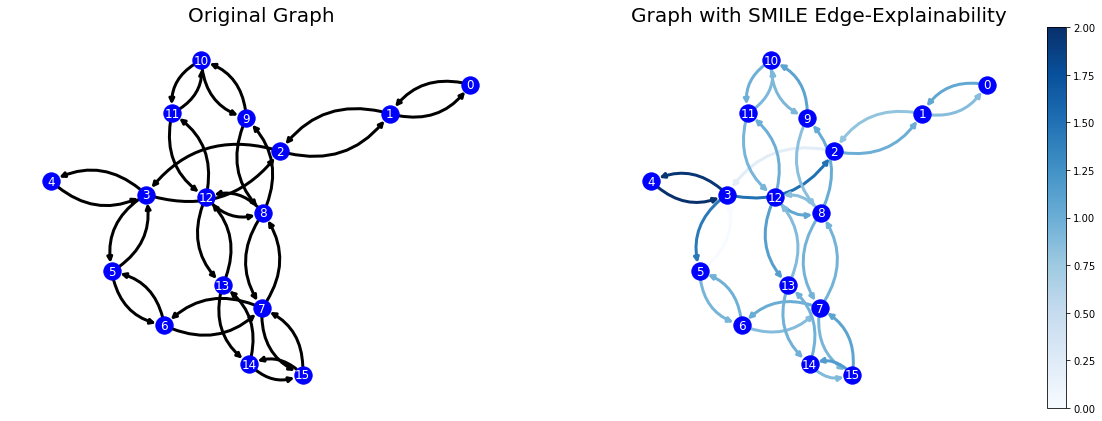

In [23]:
import matplotlib.pyplot as plt
import networkx as nx
import random

G = graphs_nx[0].copy()
ii = 0
# G = nx.gnp_random_graph(10,0.3)
for u,v,d in G.edges(data=True):
    d['weight'] = Bounded_coeff[ii]
    ii += 1

edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

# pos = nx.spring_layout(G)

fig, axs = plt.subplots(1,2,figsize=(20,7))

nx.draw(G, pos, node_color='b', width=3.0, edge_cmap=plt.cm.Blues,with_labels=True, 
        font_color='white',connectionstyle='arc3, rad = 0.35', ax = axs[0])

nx.draw(G, pos, node_color='b', edgelist=edges, edge_color=weights, width=3.0, edge_cmap=plt.cm.Blues,with_labels=True, 
        font_color='white',connectionstyle='arc3, rad = 0.35', ax = axs[1])

colors=range(3)
cmap=plt.cm.Blues
vmin = min(colors)
vmax = max(colors)
# nx.draw(G, pos, node_color='#A0CBE2', edge_color=colors, width=4, edge_cmap=cmap,
#            with_labels=False, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []

axs[0].set_title('Original Graph',fontsize=20)
axs[1].set_title('Graph with SMILE Edge-Explainability',fontsize=20)

plt.colorbar(sm)
plt.show()

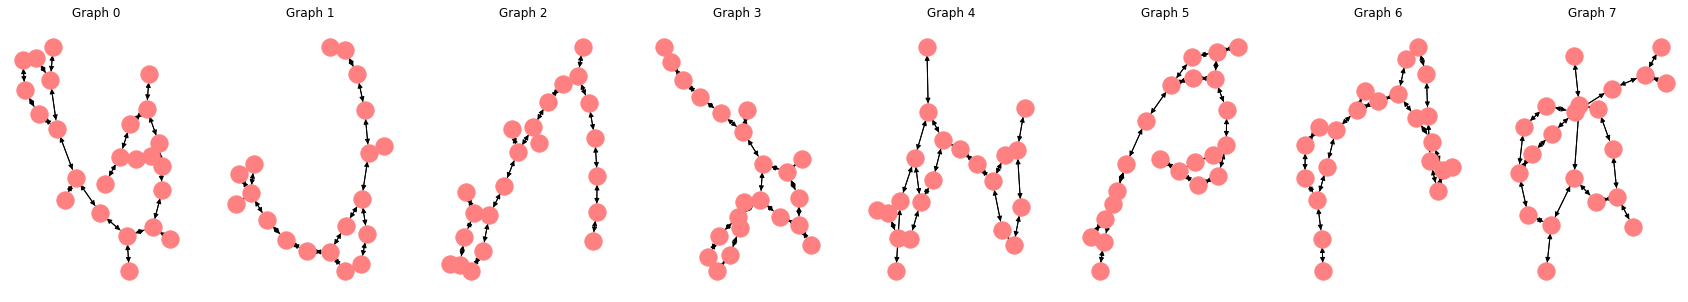

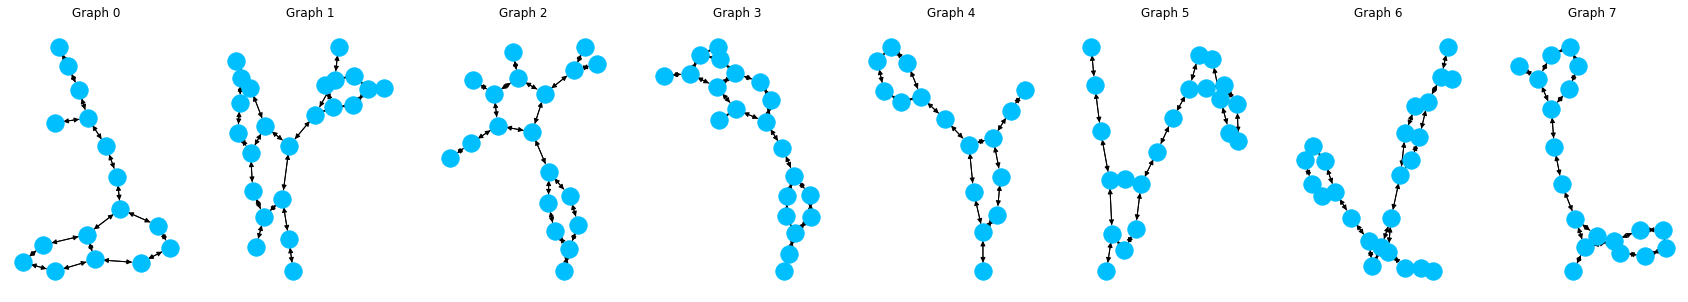

In [24]:
graphs_nx_1 = []
graphs_nx_0 = []

for ii, g_net_ii in enumerate(graphs_nx):
    if exp.y_test[ii] == 1:
        graphs_nx_1.append(g_net_ii)
    else:
        graphs_nx_0.append(g_net_ii)
        
nx_g_plotter(graphs_nx_1, ColNum=8, node_clr='#ff8080')
nx_g_plotter(graphs_nx_0, ColNum=8, node_clr='#00bfff')

7 13 432 34


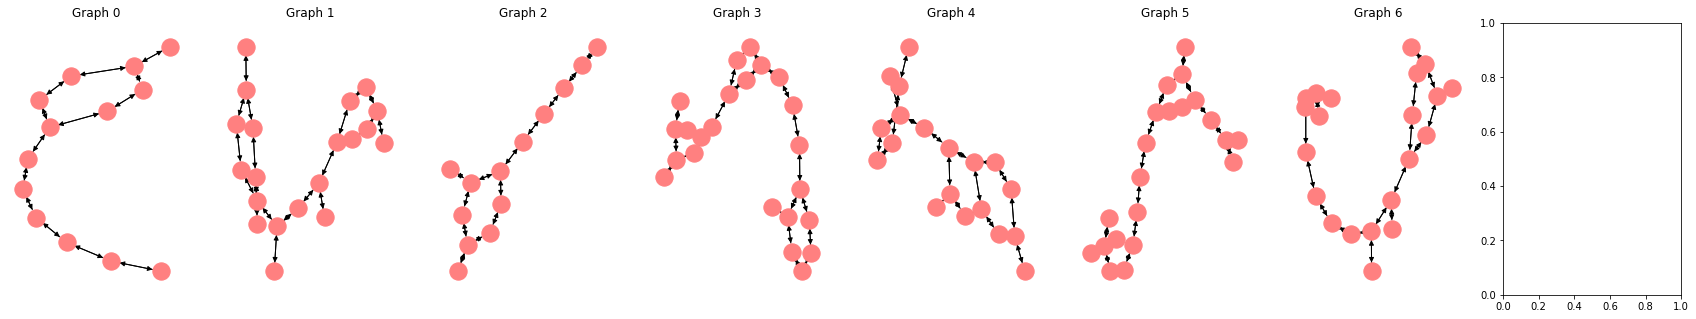

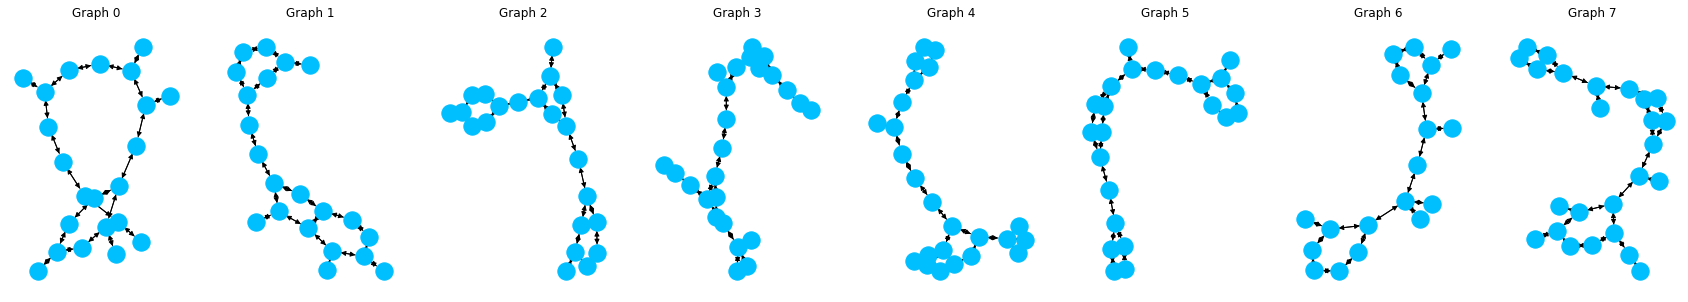

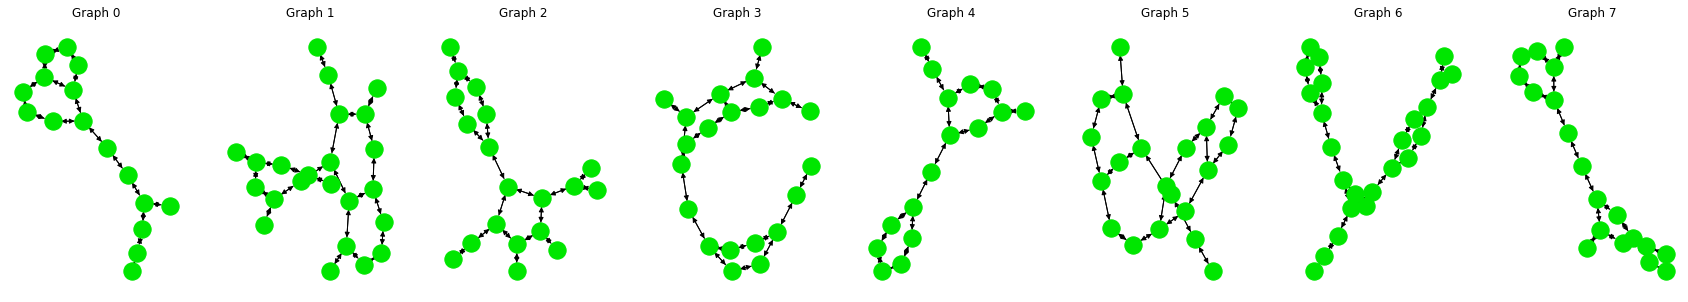

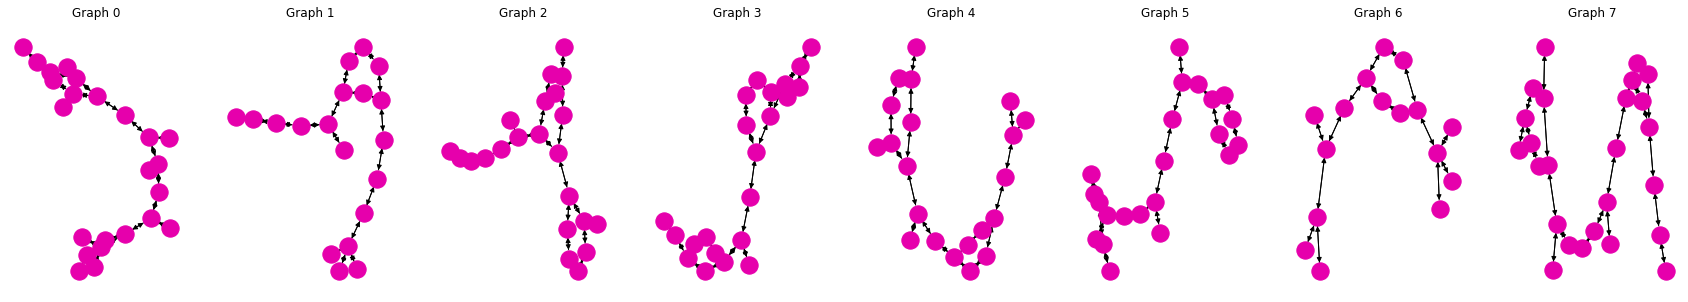

In [25]:
graphs_nx_wrong0 = []
graphs_nx_wrong1 = []
graphs_nx_correct0 = []
graphs_nx_correct1 = []

y_pred2 = model(exp.x_test).numpy()

y_wrong0 = []
y_wrong1 = []
y_correct0 = []
y_correct1 = []

for ii, g_net_ii in enumerate(graphs_nx):
    if exp.y_test[ii] != y_pred[ii] and exp.y_test[ii] == 0:
        graphs_nx_wrong0.append(g_net_ii)
        y_wrong0.append(y_pred2[ii])
    elif exp.y_test[ii] != y_pred[ii] and exp.y_test[ii] == 1:
        graphs_nx_wrong1.append(g_net_ii)
        y_wrong1.append(y_pred2[ii])
    elif exp.y_test[ii] == y_pred[ii] and exp.y_test[ii] == 0:
        graphs_nx_correct0.append(g_net_ii)
        y_correct0.append(y_pred2[ii])
    elif exp.y_test[ii] == y_pred[ii] and exp.y_test[ii] == 1:
        graphs_nx_correct1.append(g_net_ii)
        y_correct1.append(y_pred2[ii])
        
print(len(graphs_nx_wrong0), len(graphs_nx_wrong1), len(graphs_nx_correct0), len(graphs_nx_correct1))

nx_g_plotter(graphs_nx_wrong0, ColNum=8, node_clr='#ff8080')
nx_g_plotter(graphs_nx_wrong1, ColNum=8, node_clr='#00bfff')
nx_g_plotter(graphs_nx_correct0, ColNum=8, node_clr='#00e600')
nx_g_plotter(graphs_nx_correct1, ColNum=8, node_clr='#e600ac')

In [26]:
y_yes = exp.y_test[exp.y_test == 1]
y_no = exp.y_test[exp.y_test != 1]
y_yes.shape, y_no.shape

((47,), (439,))

In [27]:
recovered_data_dict_list = graph_nets.utils_np.graphs_tuple_to_data_dicts(exp.x_test)

graphs_tuple_1 = graph_nets.utils_np.data_dicts_to_graphs_tuple(recovered_data_dict_list)